<a href="https://colab.research.google.com/github/PaulSerin/Big-Data-Framework/blob/main/Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercises**

## *Spark environment setup*




In [10]:
import os

os.environ["SPARK_VERSION"] = "spark-3.5.3"
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!echo $SPARK_VERSION-bin-hadoop3.tgz
!rm $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (166 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2024-11-29 15:42:0

In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Big Data Framework/data/"

!rm /content/spark
!ln -s /content/$SPARK_VERSION-bin-hadoop3 /content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin
!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/Big Data Framework/data/


In [12]:
!python -V

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.10.12
PySpark version 3.5.3


[2, 3]

In [13]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Exercise 3.1: Word count**

Count the number of words per line in the $DRIVE_DATA/quijote.txt file.

Repeat the exercise but this time counting the number of words in the whole file.

In [58]:
from pyspark.sql import functions as F
# so that we can use the F.split() function.

### Méthode 1 (Dataframe)

In [59]:
from pyspark.sql import functions as F

# Charger le fichier texte dans un DataFrame
file_path = os.environ["DRIVE_DATA"] + "quijote.txt"
df = spark.read.text(file_path).withColumnRenamed("value", "line")

# Étape 2 : Compter les mots par ligne
df_with_word_count = df.withColumn("word_count", F.size(F.split(F.col("line"), " ")))
df_with_word_count.show(10, truncate=False)

# Étape 3 : Compter les mots dans tout le fichier
total_word_count = df_with_word_count.agg(F.sum("word_count").alias("total_word_count"))
total_word_count.show()


+---------------------------------------------------------------------------+----------+
|line                                                                       |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|                                                                           |1         |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|                                                                           |1         |
|                                                                           |1         |
|Title: Don Quijote  

Problem : this method counts 1 word for empty lines.

We will filter thoses empty lines before

In [60]:
df_non_empty = df.filter(F.col("line").isNotNull() & (F.col("line") != ""))
df_with_word_count = df_non_empty.withColumn("word_count", F.size(F.split(F.col("line"), " ")))
df_with_word_count.show(10, truncate=False)

+---------------------------------------------------------------------------+----------+
|line                                                                       |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|Title: Don Quijote                                                         |3         |
|Author: Miguel de Cervantes Saavedra                                       |5         |
|Posting Date: April 27, 2010 [EBook #2000]                                 |7         |
|Release Date: Decemb

### Méthode 2 (RDD)

In [17]:
# Load the text file as an RDD
rdd = sc.textFile(file_path)

# Step 0: Filter out empty lines
# Strip removes leading and trailing whitespaces, and we ensure the line is not empty
rdd_non_empty = rdd.filter(lambda line: line.strip() != "")

# Step 1: Count the number of words per line (excluding empty lines)
# Split each non-empty line into words and count the number of words
word_count_per_line = rdd_non_empty.map(lambda line: len(line.split(" ")))
print("Word count per line (excluding empty lines):")
print(word_count_per_line.take(10))  # Display the first 10 results

# Step 2: Count the total number of words in the file (excluding empty lines)
# Split all non-empty lines into words, flatten the resulting lists, and count the total
total_word_count_rdd = rdd_non_empty.flatMap(lambda line: line.split(" ")).count()
print("Total word count in the file (excluding empty lines):", total_word_count_rdd)


Word count per line (excluding empty lines):
[12, 14, 13, 11, 7, 3, 5, 7, 4, 2]
Total word count in the file (excluding empty lines): 387834


### Méthode 3 (function SQL)

In [18]:
# Create a temporary view
df.createOrReplaceTempView("lines")

# Step 1: Count the number of words per line (excluding empty lines)
# Filter out rows where the line is NULL or empty
word_count_query = """
SELECT line,
       SIZE(SPLIT(line, ' ')) AS word_count
FROM lines
WHERE line IS NOT NULL AND line != ''
"""
df_word_count = spark.sql(word_count_query)
df_word_count.show(10)  # Display the first 10 results

# Step 2: Count the total number of words in the file (excluding empty lines)
# Again, exclude rows where the line is NULL or empty
total_word_count_query = """
SELECT SUM(SIZE(SPLIT(line, ' '))) AS total_word_count
FROM lines
WHERE line IS NOT NULL AND line != ''
"""
df_total_word_count = spark.sql(total_word_count_query)
df_total_word_count.show()  # Display the total word count

+--------------------+----------+
|                line|word_count|
+--------------------+----------+
|The Project Guten...|        12|
|This eBook is for...|        14|
|almost no restric...|        13|
|re-use it under t...|        11|
|with this eBook o...|         7|
|  Title: Don Quijote|         3|
|Author: Miguel de...|         5|
|Posting Date: Apr...|         7|
|Release Date: Dec...|         4|
|   Language: Spanish|         2|
+--------------------+----------+
only showing top 10 rows

+----------------+
|total_word_count|
+----------------+
|          387834|
+----------------+



## **Exercise 4.1: Pi Estimation**

Using the Monte Carlo method, estimate the value of Pi. Use the random() method from the random class.

In [19]:
import random
import numpy as np

### With RDD :

In [20]:
from pyspark.sql import SparkSession

# Step 1: Initialize SparkSession
spark = SparkSession.builder.appName("Pi Estimation").getOrCreate()

# Step 2: Number of points to simulate
NUM_POINTS = 1000000

# Step 3: Create an RDD with NUM_POINTS random samples
rdd = spark.sparkContext.parallelize(range(NUM_POINTS))

# Step 4: Function to determine if a point is inside the unit circle
def is_inside_unit_circle(_):
    x = random.random()
    y = random.random()
    return x**2 + y**2 <= 1

# Step 5: Map points to 1 if inside circle, 0 otherwise
points_inside_circle = rdd.map(is_inside_unit_circle).filter(lambda inside: inside == True).count()

# Step 6: Calculate Pi
pi_estimate = 4 * (points_inside_circle / NUM_POINTS)

# Step 7: Output the result
print(f"Estimated value of Pi using {NUM_POINTS} points: {pi_estimate}")

spark.stop()


Estimated value of Pi using 1000000 points: 3.141096


### With a Dataframe :

In [21]:
from pyspark.sql.functions import rand, pow, col

# Step 0: Initialize SparkSession
spark = SparkSession.builder.appName("Pi Estimation").getOrCreate()

# Step 1: Number of points to simulate
NUM_POINTS = 1000000  # Increase for more accuracy

# Step 2: Create a DataFrame with random x and y points
df_points = (
    spark.range(NUM_POINTS)
    .select(
        rand(seed=0).alias("x"),
        rand(seed=1).alias("y")
    )
)

# Step 3: Add a column to determine if the point is inside the unit circle
df_inside_circle = df_points.withColumn(
    "inside_circle", (pow(col("x"), 2) + pow(col("y"), 2) <= 1).cast("int")
)

# Step 4: Count points inside the circle
points_inside_circle = df_inside_circle.agg({"inside_circle": "sum"}).collect()[0][0]

# Step 5: Calculate Pi
pi_estimate = 4 * (points_inside_circle / NUM_POINTS)

# Step 6: Output the result
print(f"Estimated value of Pi using {NUM_POINTS} points: {pi_estimate}")

spark.stop()


Estimated value of Pi using 1000000 points: 3.137908


## Exercise 4.2: Inspect a log file

Upload the file /var/log/syslog from your computer to this notebook. Then, select only the "bad lines": WARNING and ERROR messages.

In [22]:
from google.colab import files
uploaded = files.upload()

Saving syslog to syslog


In [23]:
!ls

gdrive	sample_data  spark  spark-3.5.3-bin-hadoop3  syslog


In [24]:
from pyspark.sql import SparkSession

# Step 1: Assuming a SparkSession is already active
# If not, uncomment the line below to initialize it
spark = SparkSession.builder.appName("Inspect Log File").getOrCreate()

# Step 2: Load the syslog file
log_file_path = "/content/syslog"  # Replace with the uploaded file path
rdd = spark.sparkContext.textFile(log_file_path)

# Step 3: Filter lines containing "WARNING" or "ERROR"
bad_lines = rdd.filter(lambda line: "WARNING" in line or "ERROR" in line)

# Step 4: Collect and display the bad lines
bad_lines_collected = bad_lines.collect()
print("Bad lines (WARNING and ERROR messages):")
for line in bad_lines_collected:
    print(line)


Bad lines (WARNING and ERROR messages):
Nov 25 17:22:07 paul-serin ovpn-cytech.students[1358]: WARNING: file '/data/CYTECH-VPN-CLE-PERSONNELLE/client.p12' is group or others accessible
Nov 25 17:22:07 paul-serin ovpn-cytech.students[1358]: WARNING: Your certificate has expired!
Nov 25 17:22:07 paul-serin gnome-session[1456]: gnome-session-binary[1456]: WARNING: Falling back to non-systemd startup procedure due to error: GDBus.Error:org.freedesktop.DBus.Error.Spawn.ChildExited: Process org.freedesktop.systemd1 exited with status 1
Nov 25 17:22:07 paul-serin gnome-session-binary[1456]: WARNING: Falling back to non-systemd startup procedure due to error: GDBus.Error:org.freedesktop.DBus.Error.Spawn.ChildExited: Process org.freedesktop.systemd1 exited with status 1
Nov 25 17:22:15 paul-serin gnome-shell[1481]: JS WARNING: [resource:///org/gnome/shell/ui/layout.js 24]: reference to undefined property "MetaWindowXwayland"
Nov 25 17:22:21 paul-serin gnome-session[2098]: gnome-session-binary[2

Dataframe approach

In [25]:
from pyspark.sql.functions import col, when, lit

# Step 1: Load the syslog file into a DataFrame
df_logs = spark.read.text(log_file_path).withColumnRenamed("value", "line")

# Step 2: Add a column to classify lines as "bad" or "good"
# A "bad" line contains "WARNING" or "ERROR", otherwise it is "good"
df_logs = df_logs.withColumn(
    "is_bad",
    when((col("line").contains("WARNING")) | (col("line").contains("ERROR")), lit(1)).otherwise(lit(0))
)

# Step 3: Count the number of bad and good lines
bad_lines_count = df_logs.filter(col("is_bad") == 1).count()
good_lines_count = df_logs.filter(col("is_bad") == 0).count()

# Step 4: Show results
print(f"Number of bad lines (WARNING or ERROR): {bad_lines_count}")
print(f"Number of good lines: {good_lines_count}")


Number of bad lines (WARNING or ERROR): 146
Number of good lines: 107068


## **Exercise 5.1: Word count**

**Using RDDs**, count the number of lines in the `$DRIVE_DATA/quijote.txt` file. Then, count the number of words in the file. Finally, count the number of *different* words in the file.


In [26]:
file_path = f"{os.environ['DRIVE_DATA']}quijote.txt"

rdd = spark.sparkContext.textFile(file_path)

rdd = rdd.filter(lambda line: line.strip() != "") # We remove empty lines

num_lines = rdd.count()

num_words = rdd.flatMap(lambda line: line.split(" ")).count()

num_distinct_words = rdd.flatMap(lambda line: line.split(" ")).distinct().count()

print(f"Number of lines: {num_lines}")
print(f"Number of words: {num_words}")
print(f"Number of different words: {num_distinct_words}")


Number of lines: 31931
Number of words: 387834
Number of different words: 40060


## **Exercise 5.2: Count people by age**

Using RDDs, create a barplot showing of number of people (y-axis) per age (x-axis) using the information in the $DRIVE_DATA/people.txt file



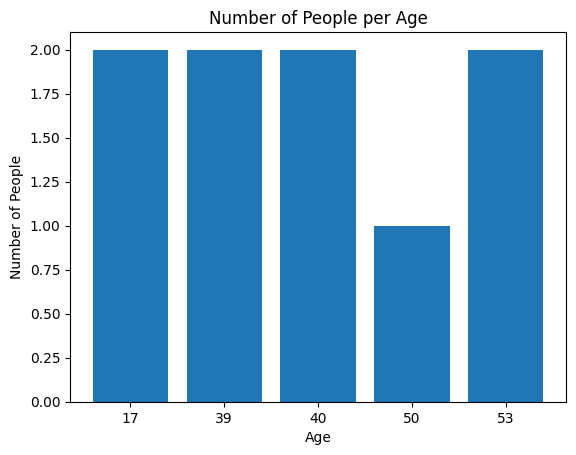

In [27]:
import matplotlib.pyplot as plt

file_path = f"{os.environ['DRIVE_DATA']}people.txt"

rdd = spark.sparkContext.textFile(file_path)

# Extract age and count occurrences
age_counts = rdd.map(lambda line: line.split("\t")[1])
age_counts = age_counts.map(lambda age: (age, 1)).reduceByKey(lambda x, y: x + y)

# Collect the results
age_counts_data = age_counts.collect()

# Sort for plotting
ages, counts = zip(*sorted(age_counts_data, key=lambda x: int(x[0])))

# Create the bar plot
plt.bar(ages, counts)
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.title("Number of People per Age")
#plt.xticks(rotation=45)
plt.show()


### **Exercise 5.3: Obtain the number of received citations**

Using RDDs, write a PySpark program that obtains, from the cite75_99.txt file, the number of citations received by each patent.


In [28]:
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

In [31]:
# Step 1: Load the file into an RDD
rdd = sc.textFile(os.environ["DRIVE_DATA"] + "/cite75_99.txt.tar.bz2")

rdd.take(100000)

# Step 2: Filter rows with a valid format
# Ensure the line contains at least one comma and has two elements when split
valid_rows = rdd.filter(lambda line: "," in line and len(line.split(",")) >= 2)

# Step 3: Extract cited patents (second column)
citations = valid_rows.map(lambda line: line.split(",")[1].strip())  # Extract the cited patent ID

# Step 4: Count citations for each patent
citations_count = citations.map(lambda patent: (patent, 1)) \
                           .reduceByKey(lambda x, y: x + y)

# Step 5: Collect and display results
citations_data = citations_count.collect()
print("Number of citations received by each patent (Top 1000):")
for patent, count in sorted(citations_data, key=lambda x: -x[1])[:1000]:
    print(f"Patent {patent}: {count} citations")


Number of citations received by each patent (Top 1000):
Patent 4723129: 779 citations
Patent 4463359: 716 citations
Patent 4740796: 678 citations
Patent 4345262: 658 citations
Patent 4558333: 654 citations
Patent 4313124: 633 citations
Patent 4683195: 631 citations
Patent 4459600: 613 citations
Patent 4683202: 605 citations
Patent 3953566: 411 citations
Patent 4367924: 401 citations
Patent 3702886: 382 citations
Patent 4733665: 360 citations
Patent 3845770: 339 citations
Patent 5103459: 311 citations
Patent 4535773: 305 citations
Patent 4358535: 292 citations
Patent 4655771: 289 citations
Patent 4901307: 287 citations
Patent 3849241: 286 citations
Patent 4234435: 280 citations
Patent 3271922: 278 citations
Patent 4340563: 276 citations
Patent 4776337: 273 citations
Patent 4440871: 273 citations
Patent 4558413: 267 citations
Patent 4647447: 262 citations
Patent 4100324: 261 citations
Patent 5111638: 254 citations
Patent 5167024: 252 citations
Patent 4258264: 251 citations
Patent 3755704

## Exercise 11.1:

A long time ago in a galaxy far, far away, the characters of the Star Wars franchise interacted with each other in an endless series of films. An ancient Jedi order, called the *Data Guardians of the Galaxy* (not affiliated to Marvel's homonym :) registered all those interactions and saved them on a digital file so that they could be studied by the forthcoming generations. This file was originally called (guess it) `sw.txt`, and you will find it in the `/data` directory.

Using pySpark, perform the following operations and answer the following questions:

1. Load the `$DRIVE_DATA/sw.txt` file. Take into account that it is a JSON file.
2. Using this information, create a graph of interactions between the Star Wars characters.
3. How many different characters are there?
4. How many interactions are there?
5. Who is the central character in Star Wars (the one who interacts in most scenes)?
6. Who is the character with the highest 'rank' in Star Wars (use the PageRank algorithm)?

*1 : Load the $DRIVE_DATA/sw.txt file. Take into account that it is a JSON file.*

In [32]:
from re import MULTILINE
sw_DF = spark.read.json(os.environ["DRIVE_DATA"] + "sw.txt", multiLine=True).cache()
sw_DF.printSchema()
sw_DF.show(truncate=False)


root
 |-- links: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- source: long (nullable = true)
 |    |    |-- target: long (nullable = true)
 |    |    |-- value: long (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- colour: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- value: long (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

*2 : Using this information, create a graph of interactions between the Star Wars characters.*

In [33]:
from pyspark.sql.functions import posexplode

# Explode the 'nodes' array with positions to get IDs
nodes_DF = sw_DF.select(posexplode("nodes").alias("id", "node"))

# Flatten the nodes DataFrame
nodes_DF = nodes_DF.selectExpr("id", "node.name as name", "node.value as interactions", "node.colour as colour")

# Create a temporary view for SQL queries
nodes_DF.createOrReplaceTempView("nodes")

nodes_DF.show(truncate=False)

+---+--------------+------------+-------+
|id |name          |interactions|colour |
+---+--------------+------------+-------+
|0  |DARTH VADER   |190         |#000000|
|1  |R2-D2         |171         |#bde0f6|
|2  |CHEWBACCA     |145         |#A0522D|
|3  |BB-8          |40          |#eb5d00|
|4  |QUI-GON       |62          |#4f4fb1|
|5  |NUTE GUNRAY   |25          |#808080|
|6  |PK-4          |4           |#808080|
|7  |TC-14         |5           |#808080|
|8  |OBI-WAN       |148         |#48D1CC|
|9  |DOFINE        |4           |#808080|
|10 |RUNE          |11          |#808080|
|11 |TEY HOW       |5           |#808080|
|12 |EMPEROR       |52          |#191970|
|13 |CAPTAIN PANAKA|20          |#808080|
|14 |SIO BIBBLE    |9           |#808080|
|15 |JAR JAR       |42          |#9a9a00|
|16 |TARPALS       |4           |#808080|
|17 |BOSS NASS     |5           |#808080|
|18 |PADME         |75          |#DDA0DD|
|19 |RIC OLIE      |12          |#808080|
+---+--------------+------------+-

In [34]:
# Explode the 'links' array
links_DF = sw_DF.selectExpr("explode(links) as link")

# Flatten the links DataFrame
links_DF = links_DF.selectExpr("link.source as source", "link.target as target", "link.value as value")

links_DF.createOrReplaceTempView("links")

links_DF.show(truncate=False)

+------+------+-----+
|source|target|value|
+------+------+-----+
|0     |1     |32   |
|2     |0     |2    |
|0     |20    |5    |
|0     |4     |22   |
|0     |18    |41   |
|0     |21    |2    |
|0     |15    |12   |
|0     |22    |2    |
|0     |23    |8    |
|24    |0     |11   |
|0     |26    |3    |
|0     |27    |2    |
|0     |8     |47   |
|0     |29    |1    |
|0     |30    |1    |
|13    |0     |2    |
|0     |19    |4    |
|0     |32    |9    |
|0     |33    |2    |
|0     |34    |9    |
+------+------+-----+
only showing top 20 rows



*3. How many different characters are there?*

In [35]:
num_characters = spark.sql("SELECT COUNT(DISTINCT name) AS num_characters FROM nodes").collect()[0][0]
print(f"Number of different characters: {num_characters}")


Number of different characters: 111


*4. How many interactions are there?*

In [36]:
num_interactions = spark.sql("SELECT COUNT(*) AS num_interactions FROM links").collect()[0][0]
print(f"Number of interactions: {num_interactions}")

Number of interactions: 444


*5. Who is the central character in Star Wars (the one who interacts in most scenes)?*

In [37]:
# Count the number of outgoing interactions for each source
out_degree_DF = spark.sql("SELECT source AS id, COUNT(*) AS out_degree FROM links GROUP BY source")

out_degree_DF.createOrReplaceTempView("out_degree")

out_degree_DF.show(truncate=False)

+---+----------+
|id |out_degree|
+---+----------+
|26 |6         |
|29 |7         |
|65 |1         |
|0  |39        |
|22 |2         |
|50 |2         |
|94 |5         |
|110|2         |
|32 |6         |
|84 |1         |
|39 |3         |
|98 |1         |
|25 |4         |
|95 |7         |
|68 |8         |
|6  |1         |
|72 |14        |
|87 |5         |
|58 |2         |
|107|1         |
+---+----------+
only showing top 20 rows



In [38]:
# Count the number of incoming interactions for each target
in_degree_DF = spark.sql("SELECT target AS id, COUNT(*) AS in_degree FROM links GROUP BY target")

in_degree_DF.createOrReplaceTempView("in_degree")

in_degree_DF.show(truncate=False)

+---+---------+
|id |in_degree|
+---+---------+
|26 |3        |
|29 |7        |
|65 |2        |
|19 |7        |
|54 |6        |
|0  |13       |
|22 |1        |
|7  |5        |
|77 |2        |
|34 |17       |
|50 |5        |
|94 |5        |
|110|2        |
|57 |2        |
|32 |7        |
|43 |4        |
|31 |4        |
|98 |9        |
|71 |3        |
|6  |1        |
+---+---------+
only showing top 20 rows



In [39]:
central_character_DF = spark.sql("""
SELECT
    nodes.name,
    COALESCE(out_degree.out_degree, 0) + COALESCE(in_degree.in_degree, 0) AS total_interactions
FROM
    nodes
LEFT JOIN
    out_degree ON nodes.id = out_degree.id
LEFT JOIN
    in_degree ON nodes.id = in_degree.id
ORDER BY
    total_interactions DESC
""")

# Show the top character
central_character = central_character_DF.first()
print(f"The central character is {central_character['name']} with {central_character['total_interactions']} interactions.")


The central character is DARTH VADER with 52 interactions.


*6. Who is the character with the highest 'rank' in Star Wars (use the PageRank algorithm)?*

In [40]:
# Initialize RDDs
edges_rdd = links_DF.rdd.map(lambda row: (row["source"], row["target"]))
vertices_rdd = nodes_DF.rdd.map(lambda row: (row["id"], row["name"]))

# Create adjacency list
links_rdd = edges_rdd.groupByKey().mapValues(list)

# Initialize ranks
ranks_rdd = vertices_rdd.mapValues(lambda _: 1.0)

# Run PageRank for 10 iterations
for _ in range(10):
    contributions = links_rdd.join(ranks_rdd).flatMap(
        lambda x: [(target, x[1][1] / len(x[1][0])) for target in x[1][0]]
    )
    ranks_rdd = contributions.reduceByKey(lambda x, y: x + y).mapValues(lambda rank: 0.15 + 0.85 * rank)

# Combine with character names and sort by rank
pagerank_results = ranks_rdd.join(vertices_rdd).map(lambda x: (x[1][1], x[1][0])).sortBy(lambda x: -x[1])

# Display the results
print("PageRank results:")
for name, rank in pagerank_results.collect():
    print(f"{name}: {rank:.4f}")

# Find the character with the highest rank
most_ranked_character = pagerank_results.take(1)[0]
print(f"The character with the highest rank is {most_ranked_character[0]} with a PageRank score of {most_ranked_character[1]:.4f}.")

PageRank results:
YODA: 0.8594
PADME: 0.4332
SHMI: 0.4325
WATTO: 0.3804
SUN RIT: 0.3728
SOLA: 0.3489
R2-D2: 0.3266
TC-14: 0.3216
SENATOR ASK AAK: 0.3204
UNKAR PLUTT: 0.3045
TARKIN: 0.2892
SNAP: 0.2837
YOLO ZIFF: 0.2837
QUI-GON: 0.2438
WEDGE: 0.2411
RED TEN: 0.2411
SIO BIBBLE: 0.2187
SEBULBA: 0.2066
POGGLE: 0.1986
WALD: 0.1928
RABE: 0.1928
OBI-WAN: 0.1865
RUWEE: 0.1864
RIC OLIE: 0.1823
VALORUM: 0.1702
MON MOTHMA: 0.1639
OWEN: 0.1639
REY: 0.1639
RED LEADER: 0.1639
ZEV: 0.1639
TION MEDON: 0.1622
PK-4: 0.1622
ODD BALL: 0.1622
TAUN WE: 0.1622
The character with the highest rank is YODA with a PageRank score of 0.8594.



---


# 12 - Exercises. Final assignment

## Exercise 12.1

Let us extract information from the cite75_99.txt and apat63_99.txt files. Write a script that performs the following operations:

1. From the cite75_99.txt file, obtain the number of citations received by each patent. You must produce a DataFrame with the following format:

| PatentNum | ncitations |
|-----------|------------|
| 3060453   |    3       |
| 3390168   |    6       |
| 3626542   |   18       |
| 3611507   |    5       |
| 3000113   |    4       |


2. From the apat63_99.txt file, create a DataFrame to show the patent number, its country and the patent year, discarding the rest of fields in the file. The DataFrame produced must have the following format:

|PatentNum |country|Year |
|----------|-------|-----|
| 3070801  | BE    | 1963|
| 3070802  | US    | 1963|
| 3070803  | US    | 1963|
| 3070804  | US    | 1963|
| 3070805  | US    | 1963|


**Requirements**

 - Both DataFrames must be stored in Parquet format with gzip compression. Check the number of partitions of each DataFrame and the number of files gererated.

 - It is **strongly advised** to copy the files from your Drive to a temporal directory in the notebook virtual machine and unzip them there. This will reduce the execution times. See the cell below:
        

In [48]:
from pyspark.sql import functions as F

cite_path = os.environ["DRIVE_DATA"] + "cite75_99.txt"
cite_df = spark.read.text(cite_path)

print("Raw data:")
cite_df.show(5, truncate=False)

# Step 1: Filter out header and split into Citing and Cited columns
cite_split_df = (
    cite_df.filter(~F.col("value").contains("CITING"))  # Remove the header
    .withColumn("Citing", F.split(F.col("value"), ",").getItem(0).cast("long"))
    .withColumn("Cited", F.split(F.col("value"), ",").getItem(1).cast("long"))
    .drop("value")
)

print("Split data:")
cite_split_df.show(5, truncate=False)

cite_split_df.createOrReplaceTempView("cite_data")

citations_sql_df = spark.sql("""
    SELECT Cited AS PatentNum, COUNT(*) AS ncitations
    FROM cite_data
    GROUP BY Cited
    ORDER BY Cited
""")

print("Citations count (SQL):")
citations_sql_df.show(5, truncate=False)

output_path_citations_sql = "/tmp/data/citations_count.parquet"
citations_sql_df.write.parquet(output_path_citations_sql, compression="gzip", mode="overwrite")

# Verify the saved Parquet files
print(f"Number of partitions (SQL): {citations_sql_df.rdd.getNumPartitions()}")
!ls -lh {output_path_citations_sql}


Raw data:
+----------------+
|value           |
+----------------+
|"CITING","CITED"|
|3858241,956203  |
|3858241,1324234 |
|3858241,3398406 |
|3858241,3557384 |
+----------------+
only showing top 5 rows

Split data:
+-------+-------+
|Citing |Cited  |
+-------+-------+
|3858241|956203 |
|3858241|1324234|
|3858241|3398406|
|3858241|3557384|
|3858241|3634889|
+-------+-------+
only showing top 5 rows

Citations count (SQL):
+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|1        |2         |
|13       |2         |
|24       |1         |
|29       |1         |
|31       |2         |
+---------+----------+
only showing top 5 rows

Number of partitions (SQL): 2
total 6.5M
-rw-r--r-- 1 root root 3.2M Nov 29 16:45 part-00000-3e1e3b37-02bd-4e90-b86b-8cb09e2d354b-c000.gz.parquet
-rw-r--r-- 1 root root 3.2M Nov 29 16:45 part-00001-3e1e3b37-02bd-4e90-b86b-8cb09e2d354b-c000.gz.parquet
-rw-r--r-- 1 root root    0 Nov 29 16:45 _SUCCESS


In [49]:
from pyspark.sql import functions as F

apat_path = os.environ["DRIVE_DATA"] + "apat63_99.txt"

apat_df = spark.read.csv(apat_path, sep=",", header=True, inferSchema=True)

apat_df.show(5, truncate=False)

# Select relevant columns and rename them
apat_selected_df = (
    apat_df.select(F.col("PATENT").alias("PatentNum"),
                   F.col("COUNTRY").alias("country"),
                   F.col("GYEAR").alias("Year"))
)

apat_selected_df.show(5, truncate=False)

# Save as Parquet with gzip compression
output_path_apat = "/tmp/data/apat_selected.parquet"
apat_selected_df.write.parquet(output_path_apat, compression="gzip", mode="overwrite")

# Verify the saved Parquet files
print(f"Number of partitions: {apat_selected_df.rdd.getNumPartitions()}")
!ls -lh {output_path_apat}

+-------+-----+-----+-------+-------+-------+--------+-------+------+------+---+------+-----+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+
|PATENT |GYEAR|GDATE|APPYEAR|COUNTRY|POSTATE|ASSIGNEE|ASSCODE|CLAIMS|NCLASS|CAT|SUBCAT|CMADE|CRECEIVE|RATIOCIT|GENERAL|ORIGINAL|FWDAPLAG|BCKGTLAG|SELFCTUB|SELFCTLB|SECDUPBD|SECDLWBD|
+-------+-----+-----+-------+-------+-------+--------+-------+------+------+---+------+-----+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+
|3070801|1963 |1096 |NULL   |BE     |NULL   |NULL    |1      |NULL  |269   |6  |69    |NULL |1       |NULL    |0.0    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |
|3070802|1963 |1096 |NULL   |US     |TX     |NULL    |1      |NULL  |2     |6  |63    |NULL |0       |NULL    |NULL   |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |
|3070803|1963 |1096 |NULL   |US     |IL     |NULL    |1      |NULL  |2     |6  |63   

## Exercise 12.2

Write a code that, from the Parquet files created in the previous exercise, obtains for each country and for each year: the total number of patents, the total number of citations from those patents, the average number of citations and the maximum number of citations. Compute only those values in which there are any values in both files (*inner join*). In addition, each country must show its whole name, obtained from the *country_codes.txt* file. The final DataFrame must look like this one:


|Country            |Year|PatentsNum |TotalCitations|AvgCitations      |MaxCitations|
|-------------------|----|-----------|--------------|------------------|------------|
|Algeria            |1963|2          |7             |3.5               |4           |
|Algeria            |1968|1          |2             |2.0               |2           |
|Algeria            |1970|1          |2             |2.0               |2           |
|Algeria            |1972|1          |1             |1.0               |1           |
|Algeria            |1977|1          |2             |2.0               |2           |
|Andorra            |1987|1          |3             |3.0               |3           |
|Andorra            |1993|1          |1             |1.0               |1           |
|Andorra            |1998|1          |1             |1.0               |1           |
|Antigua and Barbuda|1978|1          |6             |6.0               |6           |
|Antigua and Barbuda|1979|1          |14            |14.0              |14          |
|Antigua and Barbuda|1991|1          |8             |8.0               |8           |
|Antigua and Barbuda|1994|1          |19            |19.0              |19          |
|Antigua and Barbuda|1995|2          |12            |6.0               |11          |
|Antigua and Barbuda|1996|2          |3             |1.5               |2           |
|Argentina          |1963|14         |35            |2.5               |7           |
|Argentina          |1964|20         |60            |3.0               |8           |
|Argentina          |1965|10         |35            |3.5               |10          |
|Argentina          |1966|16         |44            |2.75              |9           |
|Argentina          |1967|13         |60            |4.615384615384615 |14          |

**Requirements**

- The output DataFrame must be saved in a single CSV file, with a header and without any compression.


In [51]:
from pyspark.sql import functions as F

# Load the Parquet files
citations_df = spark.read.parquet("/tmp/data/citations_count.parquet")
patents_df = spark.read.parquet("/tmp/data/apat_selected.parquet")

print("Citations DataFrame:")
citations_df.show(5, truncate=False)

print("Patents DataFrame:")
patents_df.show(5, truncate=False)

# Inner join between patents and citations using PatentNum
joined_df = patents_df.join(
    citations_df,
    patents_df.PatentNum == citations_df.PatentNum,  # Fix here: Match on PatentNum
    how="inner"
).drop(citations_df.PatentNum)  # Drop redundant PatentNum column from citations_df

# Group and aggregate
aggregated_df = joined_df.groupBy("country", "Year").agg(
    F.count("PatentNum").alias("PatentsNum"),
    F.sum("ncitations").alias("TotalCitations"),
    F.avg("ncitations").alias("AvgCitations"),
    F.max("ncitations").alias("MaxCitations")
)

# Load the country codes file
country_codes_path = os.environ["DRIVE_DATA"] + "country_codes.txt"
country_codes_df = spark.read.csv(country_codes_path, sep="\t", header=False, inferSchema=True)

# Rename columns for clarity
country_codes_df = country_codes_df.withColumnRenamed("_c0", "code").withColumnRenamed("_c1", "name")

# Verify the schema of country_codes_df
print("Country Codes DataFrame:")
country_codes_df.show(5, truncate=False)

# Join to replace country codes with full names and sort by Country and Year
final_df = aggregated_df.join(
    country_codes_df,
    aggregated_df.country == country_codes_df.code,
    how="inner"
).select(
    F.col("name").alias("Country"),
    "Year",
    "PatentsNum",
    "TotalCitations",
    "AvgCitations",
    "MaxCitations"
).orderBy("Country", "Year")  # Sort by Country (alphabetical) and Year (ascending)

print("Final DataFrame (sorted):")
final_df.show(10, truncate=False)

# Save the final DataFrame as a single CSV file
output_path = "/tmp/data/final_patents_citations.csv"
final_df.coalesce(1).write.csv(output_path, header=True, mode="overwrite")

# Verify the saved CSV file
print("Saved CSV File:")
!ls -lh {output_path}


Citations DataFrame:
+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|1        |2         |
|13       |2         |
|24       |1         |
|29       |1         |
|31       |2         |
+---------+----------+
only showing top 5 rows

Patents DataFrame:
+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|3070801  |BE     |1963|
|3070802  |US     |1963|
|3070803  |US     |1963|
|3070804  |US     |1963|
|3070805  |US     |1963|
+---------+-------+----+
only showing top 5 rows

Country Codes DataFrame:
+----+--------------+
|code|name          |
+----+--------------+
|AF  |Afghanistan   |
|AX  |Aland Islands |
|AL  |Albania       |
|DZ  |Algeria       |
|AS  |American Samoa|
+----+--------------+
only showing top 5 rows

Final DataFrame (sorted):
+-------------------+----+----------+--------------+------------+------------+
|Country            |Year|PatentsNum|TotalCitations|AvgCitations|MaxCitations|
+-------------------+----+----------+---------

## Exercise 12.3

From the apat63_99.txt file, obtain the number of patents per country and year **using RDDs** (do not use DataFrames). The resulting RDD must be a key/value RDD in which the key is a country and the value a list of tuples. Each tuple will be composed of a year and the number of patents of the country during that year. In addition, the resulting RDD must be sorted by  the country code and, for each country, values must be sorted by year.

Example of output key/value entry:

    (u'PA', [(u'1963', 2), (u'1964', 2), (u'1965', 1), (u'1966', 1), (u'1970', 1), (u'1971', 1), (u'1972', 6), (u'1974', 3), (u'1975', 5), (u'1976', 3), (u'1977', 2), (u'1978', 2), (u'1980', 2), (u'1982', 1), (u'1983', 1), (u'1985', 2), (u'1986', 1), (u'1987', 2), (u'1988', 1), (u'1990', 1), (u'1991', 2), (u'1993', 1), (u'1995', 1), (u'1996', 1), (u'1999', 1)])

**Requirements:**

- You must remove the double quotation marks from the country code.
- Use 8 partitions to read the apat63_99.txt.bz2 file.


In [52]:
apat_rdd = spark.sparkContext.textFile(os.environ["DRIVE_DATA"] + "apat63_99.txt", minPartitions=8)

# Remove the header row
header = apat_rdd.first()
print(f"Header: {header}")
apat_rdd = apat_rdd.filter(lambda line: line != header)
print("First 5 lines after removing header:")
print(apat_rdd.take(5))

# Parse the data and handle malformed lines
def parse_line(line):
    fields = line.split(",")
    if len(fields) > 4:  # Ensure there are enough fields
        country = fields[4].replace('"', '')  # Remove double quotes from the country code
        year = fields[1]
        return country, year
    else:
        return None  # Return None for malformed lines

# Apply parsing and filter out invalid rows
parsed_rdd = apat_rdd.map(parse_line)
print("First 5 parsed lines (including None for malformed):")
print(parsed_rdd.take(5))

parsed_rdd = parsed_rdd.filter(lambda x: x is not None)
print("First 5 valid parsed lines:")
print(parsed_rdd.take(5))

# Map to ((country, year), 1), reduce to count patents per (country, year)
country_year_rdd = (
    parsed_rdd.map(lambda pair: ((pair[0], pair[1]), 1))  # Map to ((country, year), 1)
    .reduceByKey(lambda x, y: x + y)  # Count patents per (country, year)
)

print("First 5 entries after reduceByKey:")
print(country_year_rdd.take(5))  # Print reduced key-value pairs

# Transform to (country, (year, count)) and group by country
grouped_rdd = (
    country_year_rdd.map(lambda pair: (pair[0][0], (pair[0][1], pair[1])))  # Transform to (country, (year, count))
    .groupByKey()  # Group by country
)

print("First 5 grouped entries by country:")
print(grouped_rdd.mapValues(list).take(5))  # Print grouped entries (convert iterator to list for printing)

# Sort by year for each country and then by country code
sorted_rdd = (
    grouped_rdd.mapValues(lambda years: sorted(list(years), key=lambda x: x[0]))  # Sort by year for each country
    .sortByKey()
)

result = sorted_rdd.collect()
print("Final result (first 5 entries):")
print(result[:5])


Header: "PATENT","GYEAR","GDATE","APPYEAR","COUNTRY","POSTATE","ASSIGNEE","ASSCODE","CLAIMS","NCLASS","CAT","SUBCAT","CMADE","CRECEIVE","RATIOCIT","GENERAL","ORIGINAL","FWDAPLAG","BCKGTLAG","SELFCTUB","SELFCTLB","SECDUPBD","SECDLWBD"
First 5 lines after removing header:
['3070801,1963,1096,,"BE","",,1,,269,6,69,,1,,0,,,,,,,', '3070802,1963,1096,,"US","TX",,1,,2,6,63,,0,,,,,,,,,', '3070803,1963,1096,,"US","IL",,1,,2,6,63,,9,,0.3704,,,,,,,', '3070804,1963,1096,,"US","OH",,1,,2,6,63,,3,,0.6667,,,,,,,', '3070805,1963,1096,,"US","CA",,1,,2,6,63,,1,,0,,,,,,,']
First 5 parsed lines (including None for malformed):
[('BE', '1963'), ('US', '1963'), ('US', '1963'), ('US', '1963'), ('US', '1963')]
First 5 valid parsed lines:
[('BE', '1963'), ('US', '1963'), ('US', '1963'), ('US', '1963'), ('US', '1963')]
First 5 entries after reduceByKey:
[(('AT', '1963'), 86), (('SE', '1963'), 386), (('MA', '1963'), 3), (('VE', '1963'), 9), (('CU', '1963'), 8)]
First 5 grouped entries by country:
[('CH', [('1977'

## Exercise 12.4

From the Parquet files created in Exercise 12.1, create a DataFrame that gives the patent or patents with the higher number of citations per country and year, as well as the average of the number of citations per country and year, and the difference between the maximum and the average values. The resulting DataFrame should look like this:


|Country|Year|PatentNum|max  |average       |diff              |
|-------|----|---------|-----|--------------|------------------|
|AD     |1987|4688621  |3    |3.0           |0.0               |
|AD     |1993|5193231  |1    |1.0           |0.0               |
|AD     |1998|5765303  |1    |1.0           |0.0               |
|AE     |1984|4482959  |5    |5.0           |0.0               |
|AE     |1985|4554981  |14   |14.0          |0.0               |
|AE     |1987|4663181  |3    |3.0           |0.0               |
|AE     |1989|4805221  |7    |5.0           |2.0               |
|AE     |1990|4909321  |2    |2.0           |0.0               |
|AE     |1991|5004552  |3    |2.0           |1.0               |
|AE     |1992|5104556  |4    |4.0           |0.0               |
|AE     |1993|5181569  |8    |8.0           |0.0               |
|AE     |1996|5580125  |1    |1.0           |0.0               |
|AG     |1978|4126850  |6    |6.0           |0.0               |
|AG     |1979|4172981  |14   |14.0          |0.0               |
|AG     |1991|5013035  |8    |8.0           |0.0               |
|AG     |1994|5345071  |19   |19.0          |0.0               |
|AG     |1995|5457307  |11   |6.0           |5.0               |
|AG     |1996|5525786  |2    |1.5           |0.5               |

**Requirements:**

- The DataFrame must be sorted by country code and year.
- Do **NOT** replace the country code by its whole name.
- The output must be saved as a single CSV file, with a header and without any compression.


In [54]:
citations_df = spark.read.parquet("/tmp/data/citations_count.parquet")
patents_df = spark.read.parquet("/tmp/data/apat_selected.parquet")

# Create temporary views for the DataFrames
citations_df.createOrReplaceTempView("citations")
patents_df.createOrReplaceTempView("patents")

# SQL Query 1: Join patents and citations
joined_query = """
    SELECT
        p.country,
        p.Year,
        p.PatentNum,
        c.ncitations
    FROM patents p
    INNER JOIN citations c
    ON p.PatentNum = c.PatentNum
"""
joined_df = spark.sql(joined_query)
joined_df.createOrReplaceTempView("joined")

# SQL Query 2: Compute max and average citations
aggregated_query = """
    SELECT
        country,
        Year,
        MAX(ncitations) AS max,
        AVG(ncitations) AS average
    FROM joined
    GROUP BY country, Year
"""
aggregated_df = spark.sql(aggregated_query)
aggregated_df.createOrReplaceTempView("aggregated")

# SQL Query 3: Find patents with the maximum number of citations
result_query = """
    SELECT DISTINCT
        agg.country AS Country,
        agg.Year AS Year,
        j.PatentNum AS PatentNum,
        agg.max AS max,
        agg.average AS average,
        (agg.max - agg.average) AS diff
    FROM aggregated agg
    INNER JOIN joined j
    ON agg.country = j.country
       AND agg.Year = j.Year
       AND agg.max = j.ncitations
    ORDER BY Country, Year
"""
result_df = spark.sql(result_query)

print("Final DataFrame:")
result_df.show(10, truncate=False)

# Save the resulting DataFrame as a single CSV file with a header and no compression
output_path = "/tmp/data/patents_max_avg_diff_sql.csv"
result_df.coalesce(1).write.csv(output_path, header=True, mode="overwrite")

# Verify the saved CSV file
print("Saved CSV File:")
!ls -lh {output_path}


Final DataFrame:
+-------+----+---------+---+-------+----+
|Country|Year|PatentNum|max|average|diff|
+-------+----+---------+---+-------+----+
|AD     |1987|4688621  |3  |3.0    |0.0 |
|AD     |1993|5193231  |1  |1.0    |0.0 |
|AD     |1998|5765303  |1  |1.0    |0.0 |
|AE     |1984|4482959  |5  |5.0    |0.0 |
|AE     |1985|4554981  |14 |14.0   |0.0 |
|AE     |1987|4663181  |3  |3.0    |0.0 |
|AE     |1989|4805221  |7  |5.0    |2.0 |
|AE     |1990|4909321  |2  |2.0    |0.0 |
|AE     |1991|5004552  |3  |2.0    |1.0 |
|AE     |1992|5104556  |4  |4.0    |0.0 |
+-------+----+---------+---+-------+----+
only showing top 10 rows

Saved CSV File:
total 116K
-rw-r--r-- 1 root root 115K Nov 29 16:50 part-00000-5b7cb170-a2a4-4884-a04b-8667873f62fd-c000.csv
-rw-r--r-- 1 root root    0 Nov 29 16:50 _SUCCESS


## Exercise 12.5

From the Parquet file with the (PatentNum,Country,Year) information from Exercise 12.1, create a DataFrame that shows the number of patents associated to each country per decade (understanding as a *decade* the years from 0 to 9; e.g. from 1970 to 1979). In addition, the DataFrame must show the increase or decrease of the number of patents per country and decade with respect to the previous decade. The resulting DataFrame must look like this:

|Country|Decade|PatentsNum|Diff|
|-------|------|----------|----|
|AD     |1980  |1         |0   |
|AD     |1990  |5         |4   |
|AE     |1980  |7         |0   |
|AE     |1990  |11        |4   |
|AG     |1970  |2         |0   |
|AG     |1990  |7         |5   |
|AI     |1990  |1         |0   |
|AL     |1990  |1         |0   |
|AM     |1990  |2         |0   |
|AN     |1970  |1         |0   |
|AN     |1980  |2         |1   |
|AN     |1990  |5         |3   |
|AR     |1960  |135       |0   |
|AR     |1970  |239       |104 |
|AR     |1980  |184       |-55 |
|AR     |1990  |292       |108 |

**Requirements**

- The DataFrame must be sorted by country code and year.
- Do **NOT** replace the country code by its whole name.
- The output must be saved as a single CSV file, with a header and without any compression.

In [55]:
from pyspark.sql import functions as F

patents_df = spark.read.parquet("/tmp/data/apat_selected.parquet")

# Compute the decade for each year
patents_with_decade_df = patents_df.withColumn(
    "Decade",
    (F.col("Year") / 10).cast("int") * 10  # Compute the decade by truncating the year to its decade
)

# Group by country and decade, and count the number of patents
grouped_df = patents_with_decade_df.groupBy("country", "Decade").agg(
    F.count("PatentNum").alias("PatentsNum")  # Count the number of patents
)

# Use a window function to compute the difference with the previous decade
from pyspark.sql.window import Window

# Define a window partitioned by country and ordered by decade
window_spec = Window.partitionBy("country").orderBy("Decade")

# Compute the difference with the previous decade
result_df = grouped_df.withColumn(
    "Diff",
    F.col("PatentsNum") - F.lag("PatentsNum", 1).over(window_spec)  # Compute difference with the previous decade
).fillna(0, subset=["Diff"])  # Fill null differences (first decade) with 0

final_df = result_df.orderBy("country", "Decade")

print("Final DataFrame:")
final_df.show(10, truncate=False)

# Save the resulting DataFrame as a single CSV file with a header and no compression
output_path = "/tmp/data/patents_per_decade.csv"
final_df.coalesce(1).write.csv(output_path, header=True, mode="overwrite")

print("Saved CSV File:")
!ls -lh {output_path}


Final DataFrame:
+-------+------+----------+----+
|country|Decade|PatentsNum|Diff|
+-------+------+----------+----+
|AD     |1980  |1         |0   |
|AD     |1990  |5         |4   |
|AE     |1980  |7         |0   |
|AE     |1990  |11        |4   |
|AG     |1970  |2         |0   |
|AG     |1990  |7         |5   |
|AI     |1990  |1         |0   |
|AL     |1990  |1         |0   |
|AM     |1990  |2         |0   |
|AN     |1970  |1         |0   |
+-------+------+----------+----+
only showing top 10 rows

Saved CSV File:
total 8.0K
-rw-r--r-- 1 root root 6.3K Nov 29 16:50 part-00000-f0fc7ee5-cafc-4075-bfdd-1a730b534f77-c000.csv
-rw-r--r-- 1 root root    0 Nov 29 16:50 _SUCCESS
